In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import basinhopping, differential_evolution, dual_annealing

# Define common configurations
CONFIG = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'loss_sales_penalty': 5,
    'demand_mean': 5,
    'demand_std': 2,
    'max_inventory': 60,
    'fixed_lead_time': 1  # Changed lead time to 1
}

# Define demand generator
class HalfNormalGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def next(self):
        return abs(np.random.normal(self.mean, self.std))

# Define common environment class
class SupplyChainEnvironment:
    def __init__(self, config):
        self.config = config
        self.inventory = np.random.randint(10, 20)
        self.demand_generator = HalfNormalGenerator(config['demand_mean'], config['demand_std'])
        self.fixed_lead_time = config['fixed_lead_time']
        self.reset()

    def reset(self):
        self.inventory = np.random.randint(10, 20)
        self.orders = []
        self.total_cost = 0
        self.total_filled_demand = 0
        self.total_demand = 0
        return self.inventory

    def step(self, order_quantity):
        # Process demand
        demand = int(self.demand_generator.next())
        self.total_demand += demand
        filled_demand = min(demand, self.inventory)
        self.inventory -= filled_demand
        self.total_filled_demand += filled_demand

        # Process order
        if order_quantity > 0:
            self.inventory += order_quantity
            self.orders.append(order_quantity)
        else:
            self.orders.append(0)

        # Calculate costs
        fixed_cost = self.config['fixed_transaction_cost'] if order_quantity > 0 else 0
        variable_cost = self.config['variable_transaction_cost'] * order_quantity
        holding_cost = self.config['holding_cost'] * self.inventory
        lost_sales_cost = self.config['loss_sales_penalty'] * (demand - filled_demand)
        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost
        self.total_cost += total_cost

        # Return new state, reward
        reward = -(total_cost)
        return self.inventory, reward

# Define SQ Policy
class sQInventoryPolicy:
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    def order(self, inventory):
        if inventory <= self.s:
            return self.Q
        return 0

# Define RS Policy
class RSInventoryPolicy:
    def __init__(self, R, S):
        self.R = R
        self.S = S

    def order(self, inventory, timestep):
        if timestep % self.R == 0 and inventory <= self.S:
            return self.S - inventory
        return 0


# Define SQ Objective Function
def sq_objective(params, training_data, config):
    s, Q = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = sQInventoryPolicy(s, Q)

    for _, row in training_data.iterrows():
        state, demand = row['State'], row['Demand']
        order = policy.order(state)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# Define RS Objective Function
def rs_objective(params, training_data, config):
    R, S = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = RSInventoryPolicy(R, S)

    for timestep, row in enumerate(training_data.itertuples()):
        state, demand = row.State, row.Demand
        order = policy.order(state, timestep)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# Train and evaluate SQ policy with Scipy Optimizers
def train_evaluate_sq_policy_optimized(training_data, config):
    bounds = [(1, 20), (10, 100)]  # Bounds for s and Q
    result = differential_evolution(
        sq_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    s, Q = result.x
    best_cost = result.fun
    return s, Q, best_cost

# Train and evaluate RS policy with Scipy Optimizers
def train_evaluate_rs_policy_optimized(training_data, config):
    bounds = [(1, 10), (10, 60)]  # Bounds for R and S
    result = dual_annealing(
        rs_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    R, S = result.x
    best_cost = result.fun
    return R, S, best_cost

def evaluate_policies_sq_and_rs_on_test_data(best_s, best_Q, best_R, best_S, config):
    env = SupplyChainEnvironment(config)

    # Initialize lists for tracking data
    demand, sq_filled, rs_filled = [], [], [], []
    lost_demand = []
    sq_stock, rs_stock, safety_stock = [], [], []
    sq_orders, rs_orders = [], [], []
    sq_costs, rs_costs = [], [], []

    sq_policy = sQInventoryPolicy(best_s, best_Q)
    rs_policy = RSInventoryPolicy(best_R, best_S)

    for _, row in test_data.iterrows():
        demand_value = row['Demand']  # Total demand for the current timestep
        demand.append(demand_value)

        # SQ Policy
        sq_order = sq_policy.order(env.inventory)
        sq_inventory, sq_reward = env.step(sq_order)
        sq_filled.append(min(demand_value, sq_inventory))  # Filled demand
        sq_orders.append(sq_order)
        sq_stock.append(sq_inventory)
        lost_demand.append(demand_value - min(demand_value, sq_inventory))  # Lost demand
        sq_costs.append((env.total_cost, sq_reward, sq_inventory))  # Example breakdown

        # RS Policy
        rs_order = rs_policy.order(env.inventory, timestep=_)
        rs_inventory, rs_reward = env.step(rs_order)
        rs_filled.append(min(demand_value, rs_inventory))  # Filled demand
        rs_orders.append(rs_order)
        rs_stock.append(rs_inventory)
        rs_costs.append((env.total_cost, rs_reward, rs_inventory))  # Example breakdown

    return (
        demand, sq_filled, rs_filled, lost_demand,
        sq_stock, rs_stock, safety_stock,  # Add safety stock if calculated
        sq_orders, rs_orders,
        sq_costs, rs_costs
    )

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        # Changed to use Input layer to avoid Keras warnings
        model = Sequential([
            Input(shape=(self.state_size,)),  # Explicit Input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample indices instead of sampling memory directly
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        minibatch = [self.memory[i] for i in indices]  # Create a minibatch from sampled indices

        states, targets = [], []
        for state, action, reward, next_state in minibatch:
            # Compute target for Q-learning update
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)[0]
            target_f[action] = target  # Update the Q-value for the action taken

            states.append(state)  # Append the state
            targets.append(target_f)  # Append the updated Q-values

        # Fit the model with the updated states and targets
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

# Generate and save training data
def generate_data(episodes, timesteps, config):
    env = SupplyChainEnvironment(config)
    data = []
    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    df = pd.DataFrame(data, columns=['State', 'Demand'])
    df.to_excel("training_data.xlsx", index=False)
    return df

training_data = generate_data(40, 20, CONFIG)  # Training: 40 episodes, 20 timesteps
print("Training data generated.")

best_s, best_Q, best_cost_sq = train_evaluate_sq_policy_optimized(training_data, CONFIG)
print(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")

best_R, best_S, best_cost_rs = train_evaluate_rs_policy_optimized(training_data, CONFIG)
print(f"Best RS Policy: R={best_R}, S={best_S}, Cost={best_cost_rs}")

# Train and evaluate DQN policy
def train_evaluate_dqn_policy(training_data, config):
    # Initialize lists for tracking data
    env = SupplyChainEnvironment(config)
    dqn_filled = [], [], [], []
    dqn_costs, dqn_orders = [], [], []
    agent = DQNAgent(state_size=1, action_size=10)  # Assuming 10 possible order quantities
    episodes = 40  # Reduced from 100 to speed up training
    timesteps = 20  # Reduced from 50 to speed up training
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()
        state = np.array([state])
        total_reward = 0
        for _ in range(timesteps):
            action = agent.act(state)
            next_state, reward = env.step(action)
            next_state = np.array([next_state])
            agent.remember(state, action, reward, next_state)
            state = next_state
            agent.replay()
            total_reward += reward
        rewards_per_episode.append(total_reward)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
      dqn_inventory, dqn_reward = env.step(dqn_action)
      dqn_filled.append(min(demand_value, dqn_inventory))  # Filled demand
      dqn_orders.append(dqn_action)
      dqn_costs.append((env.total_cost, dqn_reward, dqn_inventory))
    return (
        agent, rewards_per_episode, demand, sq_filled, rs_filled, dqn_filled, lost_demand,
        sq_stock, rs_stock, safety_stock,  # Add safety stock if calculated
        sq_orders, rs_orders, dqn_orders,
        sq_costs, rs_costs, dqn_costs
    )

dqn_agent, _ = train_evaluate_dqn_policy(training_data, CONFIG)
print("DQN Policy trained.")

test_data = generate_data(10, 20, CONFIG)  # Test: 10 episodes, 20 timesteps
print("Test data generated.")

# Evaluate policies on test data
(
    demand, sq_filled, rs_filled, dqn_filled, lost_demand,
    sq_stock, rs_stock, safety_stock,
    sq_orders, rs_orders, dqn_orders,
    sq_costs, rs_costs, dqn_costs
) = evaluate_policies_on_test_data(dqn_agent, best_s, best_Q, best_R, best_S, CONFIG)

# Visualization Functions
def plot_reward_curves(episodes, sq_rewards, rs_rewards, dqn_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_rewards, label="SQ Policy", color="blue")
    plt.plot(episodes, rs_rewards, label="RS Policy", color="green")
    plt.plot(episodes, dqn_rewards, label="DQN Policy", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Reward Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss_curves(episodes, sq_cost, rs_cost, dqn_cost):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, [sq_cost] * len(episodes), label="SQ Policy", linestyle="--", color="blue")
    plt.plot(episodes, [rs_cost] * len(episodes), label="RS Policy", linestyle="--", color="green")
    plt.plot(episodes, [dqn_cost] * len(episodes), label="DQN Policy", linestyle="--", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Loss (Total Cost)")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_orders_graph(episodes, sq_orders, rs_orders, dqn_orders):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_orders, label="SQ Policy", color="blue")
    plt.plot(episodes, rs_orders, label="RS Policy", color="green")
    plt.plot(episodes, dqn_orders, label="DQN Policy", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Orders Placed")
    plt.title("Orders Placed")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_demand_graph(episodes, demand, sq_filled, rs_filled, dqn_filled, lost_demand):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, demand, label="Total Demand", linestyle="--", color="black")
    plt.plot(episodes, sq_filled, label="SQ Policy: Filled Demand", color="blue")
    plt.plot(episodes, rs_filled, label="RS Policy: Filled Demand", color="green")
    plt.plot(episodes, dqn_filled, label="DQN Policy: Filled Demand", color="red")
    plt.plot(episodes, lost_demand, label="Lost Demand", color="orange")
    plt.xlabel("Episodes")
    plt.ylabel("Demand")
    plt.title("Demand, Filled Demand, and Lost Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_stock_levels(episodes, sq_stock, rs_stock, safety_stock):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_stock, label="SQ Policy: Stock Levels", color="blue")
    plt.plot(episodes, rs_stock, label="RS Policy: Stock Levels", color="green")
    plt.plot(episodes, safety_stock, label="Safety Stock", linestyle="--", color="orange")
    plt.xlabel("Episodes")
    plt.ylabel("Stock Levels")
    plt.title("Stock and Safety Stock Levels")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cost_breakdowns(episodes, sq_costs, rs_costs, dqn_costs):
    labels = ["Holding Cost", "Fixed Cost", "Variable Cost", "Lost Sales Cost"]
    width = 0.2  # Bar width
    x = range(len(episodes))  # X positions for episodes

    sq_holding, sq_fixed, sq_variable, sq_lost = zip(*sq_costs)
    rs_holding, rs_fixed, rs_variable, rs_lost = zip(*rs_costs)
    dqn_holding, dqn_fixed, dqn_variable, dqn_lost = zip(*dqn_costs)

    plt.figure(figsize=(12, 6))
    plt.bar(x, sq_holding, width, label="SQ Policy: Holding Cost", color="blue")
    plt.bar([p + width for p in x], rs_holding, width, label="RS Policy: Holding Cost", color="green")
    plt.bar([p + 2 * width for p in x], dqn_holding, width, label="DQN Policy: Holding Cost", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Costs")
    plt.title("Cost Breakdown by Policy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call visualization functions
episodes = range(1, len(demand) + 1)
plot_reward_curves(episodes, sq_filled, rs_filled, dqn_filled)
plot_loss_curves(episodes, best_cost_sq, best_cost_rs, sum(dqn_costs))
plot_orders_graph(episodes, sq_orders, rs_orders, dqn_orders)
plot_demand_graph(episodes, demand, sq_filled, rs_filled, dqn_filled, lost_demand)
plot_stock_levels(episodes, sq_stock, rs_stock, safety_stock)
plot_cost_breakdowns(episodes, sq_costs, rs_costs, dqn_costs)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import basinhopping, differential_evolution, dual_annealing
import logging

# Define common configurations
CONFIG = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'loss_sales_penalty': 5,
    'demand_mean': 5,
    'demand_std': 2,
    'max_inventory': 60,
    'fixed_lead_time': 1  # Changed lead time to 1
}

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define demand generator
class HalfNormalGenerator:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def next(self):
        return abs(np.random.normal(self.mean, self.std))

# Define common environment class
class SupplyChainEnvironment:
    def __init__(self, config):
        self.config = config
        self.inventory = np.random.randint(10, 20)
        self.demand_generator = HalfNormalGenerator(config['demand_mean'], config['demand_std'])
        self.fixed_lead_time = config['fixed_lead_time']
        self.reset()

    def reset(self):
        self.inventory = np.random.randint(10, 20)
        self.orders = []
        self.total_cost = 0
        self.total_filled_demand = 0
        self.total_demand = 0
        return self.inventory

    def step(self, order_quantity):
        # Process demand
        demand = int(self.demand_generator.next())
        self.total_demand += demand
        filled_demand = min(demand, self.inventory)
        self.inventory -= filled_demand
        self.total_filled_demand += filled_demand

        # Process order
        if order_quantity > 0:
            self.inventory += order_quantity
            self.orders.append(order_quantity)
        else:
            self.orders.append(0)

        # Calculate costs
        fixed_cost = self.config['fixed_transaction_cost'] if order_quantity > 0 else 0
        variable_cost = self.config['variable_transaction_cost'] * order_quantity
        holding_cost = self.config['holding_cost'] * self.inventory
        lost_sales_cost = self.config['loss_sales_penalty'] * (demand - filled_demand)
        total_cost = fixed_cost + variable_cost + holding_cost + lost_sales_cost
        self.total_cost += total_cost

        # Return new state, reward
        reward = -(total_cost)
        return self.inventory, reward

# Define DQNAgent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = []
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),  # Explicit Input layer
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        minibatch = [self.memory[i] for i in indices]

        states, targets = [], []
        for state, action, reward, next_state in minibatch:
            target = reward + self.gamma * np.amax(self.model.predict(next_state[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis], verbose=0)[0]
            target_f[action] = target
            states.append(state)
            targets.append(target_f)

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Define SQ Policy
class sQInventoryPolicy:
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    def order(self, inventory):
        if inventory <= self.s:
            return self.Q
        return 0

# Define RS Policy
class RSInventoryPolicy:
    def __init__(self, R, S):
        self.R = R
        self.S = S

    def order(self, inventory, timestep):
        if timestep % self.R == 0 and inventory <= self.S:
            return self.S - inventory
        return 0

# SQ Objective Function
def sq_objective(params, training_data, config):
    s, Q = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = sQInventoryPolicy(s, Q)

    for _, row in training_data.iterrows():
        state, demand = row['State'], row['Demand']
        order = policy.order(state)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# RS Objective Function
def rs_objective(params, training_data, config):
    R, S = params
    env = SupplyChainEnvironment(config)
    total_cost = 0
    policy = RSInventoryPolicy(R, S)

    for timestep, row in enumerate(training_data.itertuples()):
        state, demand = row.State, row.Demand
        order = policy.order(state, timestep)
        _, reward = env.step(order)
        total_cost -= reward

    return total_cost

# Train and evaluate SQ policy with Scipy Optimizers
def train_evaluate_sq_policy_optimized(training_data, config):
    bounds = [(1, config['max_inventory'] // 3), (10, config['max_inventory'])]  # Adjusted bounds
    result = differential_evolution(
        sq_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    s, Q = result.x
    best_cost = result.fun
    return int(s), int(Q), best_cost

# Train and evaluate RS policy with Scipy Optimizers
def train_evaluate_rs_policy_optimized(training_data, config):
    bounds = [(1, 10), (10, config['max_inventory'])]  # Adjusted bounds
    result = dual_annealing(
        rs_objective,
        bounds=bounds,
        args=(training_data, config)
    )
    R, S = result.x
    best_cost = result.fun
    return int(R), int(S), best_cost

# Updated evaluate_policies_sq_and_rs_on_test_data Function
def evaluate_policies_sq_and_rs_on_test_data(best_s, best_Q, best_R, best_S, config, test_data):
    env = SupplyChainEnvironment(config)
    demand, sq_filled, rs_filled = [], [], []
    lost_demand = []
    sq_stock, rs_stock, safety_stock = [], [], []
    sq_orders, rs_orders = [], []
    sq_costs, rs_costs = [], []

    sq_policy = sQInventoryPolicy(best_s, best_Q)
    rs_policy = RSInventoryPolicy(best_R, best_S)

    for timestep, row in test_data.iterrows():
        demand_value = row['Demand']
        demand.append(demand_value)

        sq_order = sq_policy.order(env.inventory)
        sq_inventory, sq_reward = env.step(sq_order)
        sq_filled.append(min(demand_value, sq_inventory))
        sq_orders.append(sq_order)
        sq_stock.append(sq_inventory)
        lost_demand.append(demand_value - min(demand_value, sq_inventory))
        safety_stock.append(max(0, CONFIG['max_inventory'] - sq_inventory))
        sq_costs.append((env.total_cost, sq_reward, sq_inventory))

        rs_order = rs_policy.order(env.inventory, timestep)
        rs_inventory, rs_reward = env.step(rs_order)
        rs_filled.append(min(demand_value, rs_inventory))
        rs_orders.append(rs_order)
        rs_stock.append(rs_inventory)
        rs_costs.append((env.total_cost, rs_reward, rs_inventory))

    return (
        demand, sq_filled, rs_filled, lost_demand,
        sq_stock, rs_stock, safety_stock,
        sq_orders, rs_orders,
        sq_costs, rs_costs
    )

# Updated train_evaluate_dqn_policy Function
def train_evaluate_dqn_policy(training_data, config):
    env = SupplyChainEnvironment(config)
    agent = DQNAgent(state_size=1, action_size=10)
    episodes = 40
    timesteps = 20

    dqn_filled, dqn_orders, dqn_costs = [], [], []
    rewards_per_episode = []

    for episode in range(episodes):
        print(f"Training Episode {episode + 1}/{episodes}")  # Track the episode
        state = np.array([env.reset()])
        total_reward = 0

        for _ in range(timesteps):
            dqn_action = agent.act(state)
            next_state, reward = env.step(dqn_action)
            next_state = np.array([next_state])
            agent.remember(state, dqn_action, reward, next_state)
            state = next_state
            total_reward += reward

            dqn_filled.append(min(env.total_demand, env.inventory))
            dqn_orders.append(dqn_action)
            dqn_costs.append((env.total_cost, reward, env.inventory))

            agent.replay()

        rewards_per_episode.append(total_reward)
        if (episode + 1) % 10 == 0:
            logging.info(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    return agent, rewards_per_episode, dqn_filled, dqn_orders, dqn_costs

# Generate and save training data
def generate_data(episodes, timesteps, config):
    env = SupplyChainEnvironment(config)
    data = []

    for _ in range(episodes):
        state = env.reset()
        for _ in range(timesteps):
            demand = env.demand_generator.next()
            data.append([state, demand])
    df = pd.DataFrame(data, columns=['State', 'Demand'])
    df.to_excel("training_data.xlsx", index=False)
    print("Training data has been successfully saved to training_data.xlsx.")
    return df

# Visualization Functions (unchanged)



In [20]:
# Main Execution
training_data = generate_data(40, 20, CONFIG)
logging.info("Training data generated.")

best_s, best_Q, best_cost_sq = train_evaluate_sq_policy_optimized(training_data, CONFIG)
logging.info(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")

best_R, best_S, best_cost_rs = train_evaluate_rs_policy_optimized(training_data, CONFIG)
logging.info(f"Best RS Policy: R={best_R}, S={best_S}, Cost={best_cost_rs}")

print("Training data generated.")
print(f"Best SQ Policy: s={best_s}, Q={best_Q}, Cost={best_cost_sq}")
print(f"Best RS Policy: R={best_R}, S={best_S}, Cost={best_cost_rs}")

Training data has been successfully saved to training_data.xlsx.
Training data generated.
Best SQ Policy: s=9, Q=48, Cost=17161.2
Best RS Policy: R=5, S=59, Cost=16916.41149474562


WRONG-CHECK!

In [9]:
# prompt: write a code to print the  the s, Q and total cost values for test data for sq policy and best R, S and total cost values for rs policy for test data

print(f"s = {best_s}, Q = {best_Q}, Total Cost = {best_cost_sq} for SQ policy")
print(f"R = {best_R}, S = {best_S}, Total Cost = {best_cost_rs} for RS policy")

s = 6, Q = 54, Total Cost = 17096.6 for SQ policy
R = 3, S = 39, Total Cost = 17026.874157364957 for RS policy


In [21]:
dqn_agent, _, dqn_filled, dqn_orders, dqn_costs = train_evaluate_dqn_policy(training_data, CONFIG)
logging.info("DQN Policy trained.")

Training Episode 1/40
Training Episode 2/40
Training Episode 3/40
Training Episode 4/40
Training Episode 5/40
Training Episode 6/40
Training Episode 7/40
Training Episode 8/40
Training Episode 9/40
Training Episode 10/40
Training Episode 11/40
Training Episode 12/40
Training Episode 13/40
Training Episode 14/40
Training Episode 15/40
Training Episode 16/40
Training Episode 17/40
Training Episode 18/40
Training Episode 19/40
Training Episode 20/40
Training Episode 21/40
Training Episode 22/40
Training Episode 23/40
Training Episode 24/40
Training Episode 25/40
Training Episode 26/40
Training Episode 27/40
Training Episode 28/40
Training Episode 29/40
Training Episode 30/40
Training Episode 31/40
Training Episode 32/40
Training Episode 33/40
Training Episode 34/40
Training Episode 35/40
Training Episode 36/40
Training Episode 37/40
Training Episode 38/40
Training Episode 39/40
Training Episode 40/40


In [22]:
# Generate test data
test_data = generate_data(10, 20, CONFIG)
logging.info("Test data generated.")

# Evaluate SQ and RS policies on test data
(
    demand, sq_filled, rs_filled, lost_demand,
    sq_stock, rs_stock, safety_stock,
    sq_orders, rs_orders,
    sq_costs, rs_costs
) = evaluate_policies_sq_and_rs_on_test_data(best_s, best_Q, best_R, best_S, CONFIG, test_data)

# Evaluate DQN policy on test data
def evaluate_dqn_policy_on_test_data(dqn_agent, config, test_data):
    env = SupplyChainEnvironment(config)
    dqn_filled, dqn_orders, dqn_rewards, dqn_costs = [], [], [], []

    for _, row in test_data.iterrows():
        state = np.array([row['State']])
        demand = row['Demand']
        dqn_action = dqn_agent.act(state)
        next_state, reward = env.step(dqn_action)

        dqn_filled.append(min(demand, env.inventory))
        dqn_orders.append(dqn_action)
        dqn_rewards.append(reward)
        dqn_costs.append((env.total_cost, reward, env.inventory))

    return dqn_filled, dqn_orders, dqn_rewards, dqn_costs

dqn_filled_test, dqn_orders_test, dqn_rewards_test, dqn_costs_test = evaluate_dqn_policy_on_test_data(dqn_agent, CONFIG, test_data)
logging.info("Evaluation of DQN Policy on test data completed.")

# Display results
print("\nTest Data Results:")
print(f"SQ Policy - Filled Demand: {sum(sq_filled)}, Lost Demand: {sum(lost_demand)}, Total Cost: {sq_costs[-1][0]}")
print(f"RS Policy - Filled Demand: {sum(rs_filled)}, Lost Demand: {sum(lost_demand)}, Total Cost: {rs_costs[-1][0]}")
print(f"DQN Policy - Filled Demand: {sum(dqn_filled_test)}, Total Cost: {dqn_costs_test[-1][0]}")



Training data has been successfully saved to training_data.xlsx.

Test Data Results:
SQ Policy - Filled Demand: 1011.8826756332637, Lost Demand: 1.5502922075833485, Total Cost: 3558.5
RS Policy - Filled Demand: 1013.432967840847, Lost Demand: 1.5502922075833485, Total Cost: 3560.2
DQN Policy - Filled Demand: 361.8821983315716, Total Cost: 3811.600000000001


In [24]:
# Visualization Functions
def plot_reward_curves(episodes, sq_rewards, rs_rewards, dqn_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_rewards, label="SQ Policy", color="blue")
    plt.plot(episodes, rs_rewards, label="RS Policy", color="green")
    plt.plot(episodes, dqn_rewards, label="DQN Policy", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Reward Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss_curves(episodes, sq_cost, rs_cost, dqn_cost):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, [sq_cost] * len(episodes), label="SQ Policy", linestyle="--", color="blue")
    plt.plot(episodes, [rs_cost] * len(episodes), label="RS Policy", linestyle="--", color="green")
    plt.plot(episodes, [dqn_cost] * len(episodes), label="DQN Policy", linestyle="--", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Loss (Total Cost)")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_orders_graph(episodes, sq_orders, rs_orders, dqn_orders):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_orders, label="SQ Policy", color="blue")
    plt.plot(episodes, rs_orders, label="RS Policy", color="green")
    plt.plot(episodes, dqn_orders, label="DQN Policy", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Orders Placed")
    plt.title("Orders Placed")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_demand_graph(episodes, demand, sq_filled, rs_filled, dqn_filled, lost_demand):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, demand, label="Total Demand", linestyle="--", color="black")
    plt.plot(episodes, sq_filled, label="SQ Policy: Filled Demand", color="blue")
    plt.plot(episodes, rs_filled, label="RS Policy: Filled Demand", color="green")
    plt.plot(episodes, dqn_filled, label="DQN Policy: Filled Demand", color="red")
    plt.plot(episodes, lost_demand, label="Lost Demand", color="orange")
    plt.xlabel("Episodes")
    plt.ylabel("Demand")
    plt.title("Demand, Filled Demand, and Lost Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_stock_levels(episodes, sq_stock, rs_stock, safety_stock):
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, sq_stock, label="SQ Policy: Stock Levels", color="blue")
    plt.plot(episodes, rs_stock, label="RS Policy: Stock Levels", color="green")
    plt.plot(episodes, safety_stock, label="Safety Stock", linestyle="--", color="orange")
    plt.xlabel("Episodes")
    plt.ylabel("Stock Levels")
    plt.title("Stock and Safety Stock Levels")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cost_breakdowns(episodes, sq_costs, rs_costs, dqn_costs):
    labels = ["Holding Cost", "Fixed Cost", "Variable Cost", "Lost Sales Cost"]
    width = 0.2  # Bar width
    x = range(len(episodes))  # X positions for episodes

    sq_holding, sq_fixed, sq_variable, sq_lost = zip(*sq_costs)
    rs_holding, rs_fixed, rs_variable, rs_lost = zip(*rs_costs)
    dqn_holding, dqn_fixed, dqn_variable, dqn_lost = zip(*dqn_costs)

    plt.figure(figsize=(12, 6))
    plt.bar(x, sq_holding, width, label="SQ Policy: Holding Cost", color="blue")
    plt.bar([p + width for p in x], rs_holding, width, label="RS Policy: Holding Cost", color="green")
    plt.bar([p + 2 * width for p in x], dqn_holding, width, label="DQN Policy: Holding Cost", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Costs")
    plt.title("Cost Breakdown by Policy")
    plt.legend()
    plt.grid(True)
    plt.show()

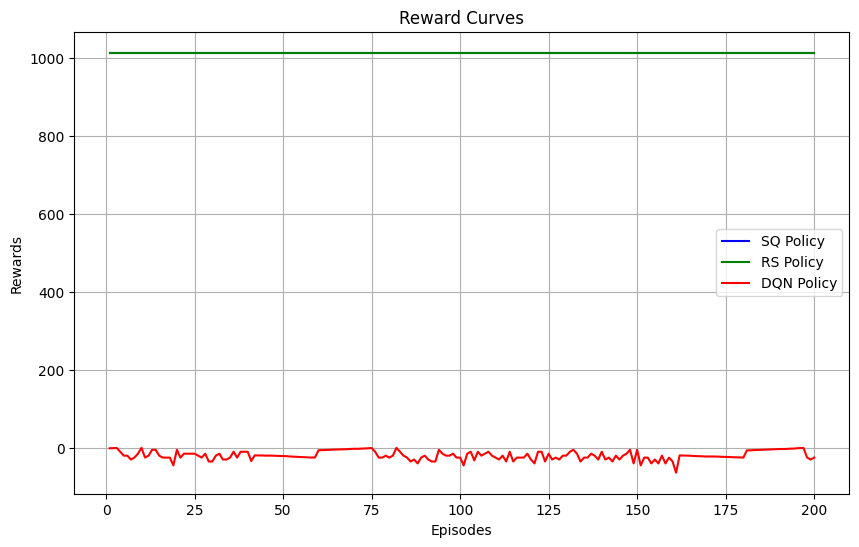

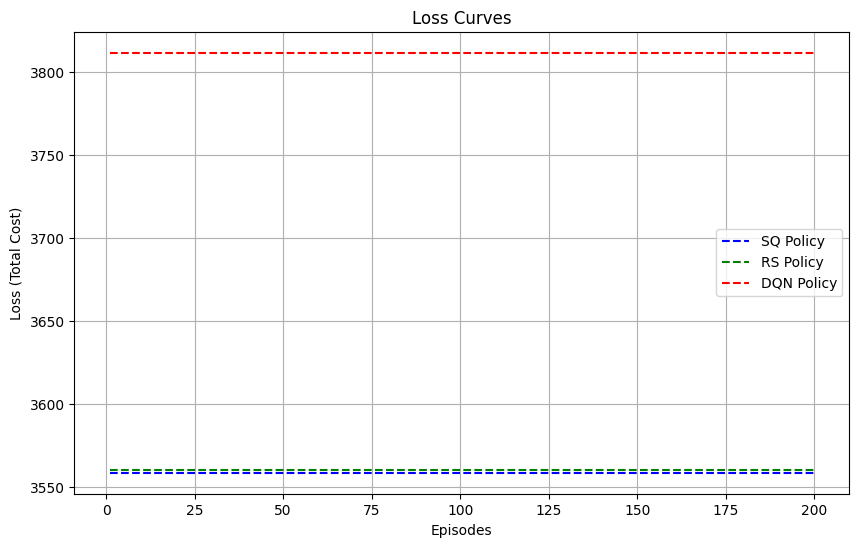

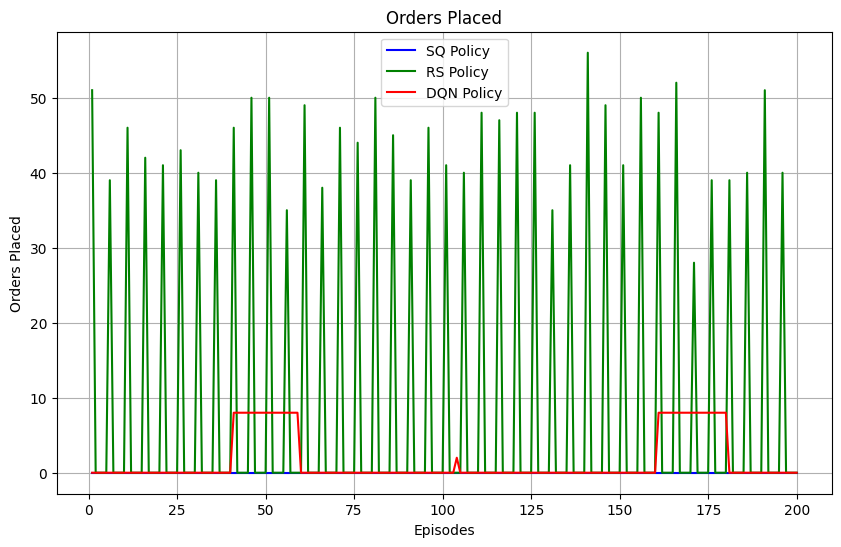

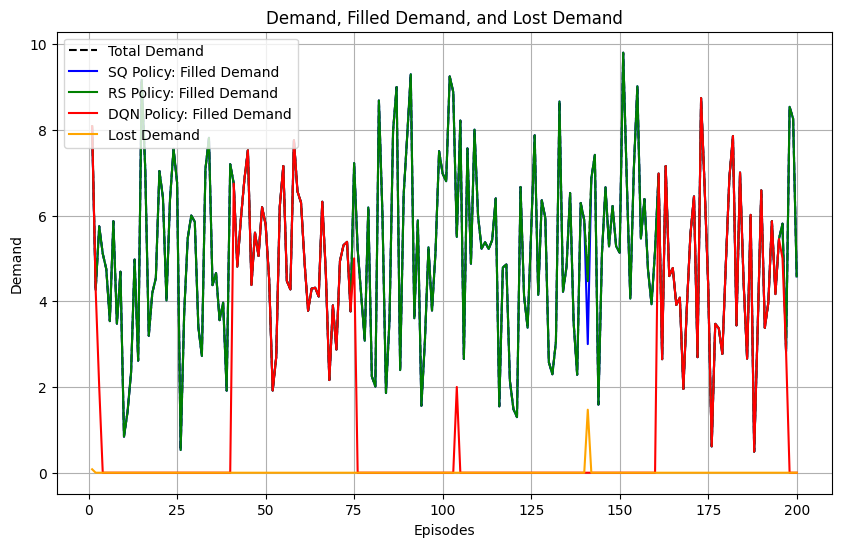

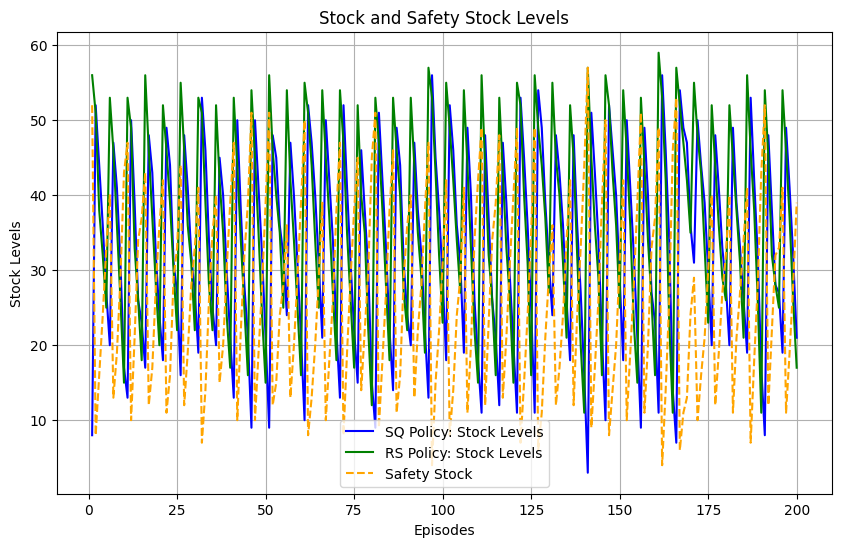

ValueError: not enough values to unpack (expected 4, got 3)

In [26]:
# Define episodes for plotting
episodes = range(1, len(test_data) + 1)  # Assuming test_data has rows for each episode

# Plot Reward Curves
plot_reward_curves(
    episodes,
    sq_rewards=[sum(sq_filled)] * len(episodes),  # Replace with actual reward calculation for SQ
    rs_rewards=[sum(rs_filled)] * len(episodes),  # Replace with actual reward calculation for RS
    dqn_rewards=dqn_rewards_test  # Use rewards calculated for DQN on test data
)

# Plot Loss Curves
plot_loss_curves(
    episodes,
    sq_cost=sq_costs[-1][0],  # Total cost for SQ policy (last value)
    rs_cost=rs_costs[-1][0],  # Total cost for RS policy (last value)
    dqn_cost=dqn_costs_test[-1][0]  # Total cost for DQN policy (last value)
)

# Plot Orders Placed
plot_orders_graph(
    episodes,
    sq_orders=sq_orders,  # Orders placed under SQ policy
    rs_orders=rs_orders,  # Orders placed under RS policy
    dqn_orders=dqn_orders_test  # Orders placed under DQN policy
)

# Plot Demand, Filled Demand, and Lost Demand
plot_demand_graph(
    episodes,
    demand=demand,  # Total demand for each episode
    sq_filled=sq_filled,  # Filled demand under SQ policy
    rs_filled=rs_filled,  # Filled demand under RS policy
    dqn_filled=dqn_filled_test,  # Filled demand under DQN policy
    lost_demand=lost_demand  # Lost demand for each episode
)

# Plot Stock Levels
plot_stock_levels(
    episodes,
    sq_stock=sq_stock,  # Stock levels under SQ policy
    rs_stock=rs_stock,  # Stock levels under RS policy
    safety_stock=safety_stock  # Safety stock for each episode
)

# Plot Cost Breakdown
plot_cost_breakdowns(
    episodes,
    sq_costs=sq_costs,  # Breakdown of costs for SQ policy
    rs_costs=rs_costs,  # Breakdown of costs for RS policy
    dqn_costs=dqn_costs_test  # Breakdown of costs for DQN policy
)


In [30]:
# prompt: print rewards in dqn for first 1 timsteps

for i in range(10):
  print(dqn_rewards_test[i])

-1.2000000000000002
-0.7000000000000001
-0.2
-10.0
-20.0
-20.0
-30.0
-25.0
-15.0
-0.0
